# Alertness‑Score Pipeline v3 – Channel Variants & Temporal Smoothing
Adds temporal stability and explores different channel subsets:
* **All 4 channels** (LF, OTE_L, RF, OTE_R)
* **Frontal only** (LF & RF)
* **Right‑frontal only** (RF)

After we predict a raw score (0‑100) every 30 s, we apply a **rolling mean window=3 epochs** (≈90 s) to damp volatility, plus a simple hysteresis when translating the score into a binary *alert* flag.


In [1]:

import os, pickle, warnings, math
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy as scipy_entropy
import mne

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
sns.set(style='whitegrid'); warnings.filterwarnings('ignore')


In [2]:

DATA_ROOT = Path('sample_data')
FS = 125
EPOCH_SEC = 30
MIN_GOOD_RATIO = 0.6
TRAIN_POS, TRAIN_NEG = 'Wake','Deep'
BANDS = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}

CHANNEL_VARIANTS = {
    'all'     : [0,1,2,3],
    'frontal' : [0,2],       # LF & RF
    'rf_only' : [2]
}


In [3]:

def bandpass(x, fs=FS, low=0.5, high=45, order=4):
    b,a = butter(order, [low/(0.5*fs), high/(0.5*fs)], btype='band')
    return filtfilt(b,a,x, axis=-1)

def hjorth_params(sig):
    act=np.var(sig); diff=np.diff(sig)
    mob=np.sqrt(np.var(diff)/act) if act else 0
    diff2=np.diff(diff)
    comp=np.sqrt(np.var(diff2)/np.var(diff)) if np.var(diff) else 0
    return act,mob,comp

def spectral_entropy(sig, fs=FS):
    f,P = welch(sig, fs=fs, nperseg=min(len(sig),4*fs))
    P_norm=P/np.sum(P) if np.sum(P) else P
    return scipy_entropy(P_norm, base=2)

def epoch_features(epoch):
    feats={}
    for ch in range(epoch.shape[0]):
        sig=epoch[ch]
        feats[f'ch{ch}_mean']=sig.mean()
        feats[f'ch{ch}_std']=sig.std()
        a,mob,com=hjorth_params(sig)
        feats[f'ch{ch}_activity']=a
        feats[f'ch{ch}_mobility']=mob
        feats[f'ch{ch}_complexity']=com
        feats[f'ch{ch}_spec_entropy']=spectral_entropy(sig)
        f,P=welch(sig, fs=FS, nperseg=min(len(sig),4*FS))
        total=np.trapz(P,f)
        for b,(lo,hi) in BANDS.items():
            idx=(f>=lo)&(f<hi); power=np.trapz(P[idx],f[idx])
            feats[f'ch{ch}_{b}_rel']=power/total if total else 0
            feats[f'ch{ch}_{b}_abs']=power
    # ratio
    if feats['ch0_alpha_abs']>0:
        feats['theta_alpha_ratio']=feats['ch0_theta_abs']/feats['ch0_alpha_abs']
    else:
        feats['theta_alpha_ratio']=0
    return feats


In [4]:

def build_epochs(rec_dir):
    edf = next(rec_dir.glob('*.edf'))
    stage_csv = next(rec_dir.glob('*[0-9].csv'))
    sqc_csv = next(rec_dir.glob('*SQC.csv'))
    raw = mne.io.read_raw_edf(edf, preload=True, verbose=False)
    raw.filter(0.5,45,fir_design='firwin',verbose=False)
    data = bandpass(raw.get_data()[:4])
    df_stage=pd.read_csv(stage_csv); df_sqc=pd.read_csv(sqc_csv)
    start_ts=df_stage['Timestamp'].min()
    rows=[]
    for _,row in df_stage.iterrows():
        ts=row['Timestamp']; lbl=row['Sleep stage']
        st=int((ts-start_ts)*FS); en=st+EPOCH_SEC*FS
        if en>data.shape[1]: break
        mask=(df_sqc['Timestamp']>=ts)&(df_sqc['Timestamp']<ts+EPOCH_SEC)
        good_ratio=(df_sqc.loc[mask,'Signal quality']=='Good').mean()
        if good_ratio<MIN_GOOD_RATIO: continue
        feats=epoch_features(data[:,st:en])
        feats.update({'good_ratio':good_ratio,'stage':lbl,'record':rec_dir.name})
        rows.append(feats)
    return pd.DataFrame(rows)


In [5]:

rec_dirs=[p for p in DATA_ROOT.iterdir() if p.is_dir()]
if not rec_dirs: raise FileNotFoundError("sample_data missing.")
base_df = pd.concat([build_epochs(p) for p in rec_dirs], ignore_index=True)
print('Base epochs:', base_df.shape)


Base epochs: (16088, 68)


In [13]:

variants_results={}
gkf=GroupKFold(n_splits=5)
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
for vname, ch_idx in CHANNEL_VARIANTS.items():
    # columns to keep
    cols = [c for c in base_df.columns if c.startswith(tuple([f'ch{i}_' for i in ch_idx]))] + ['good_ratio','theta_alpha_ratio']
    work_df = base_df[['stage','record']+cols].copy()
    train = work_df[work_df['stage'].isin([TRAIN_POS,TRAIN_NEG])].copy()
    train['y']=(train['stage']==TRAIN_POS).astype(int)
    X=train.drop(columns=['stage','record','y'])
    y=train['y']; groups=train['record']
    pipe=Pipeline([('imp',SimpleImputer(strategy='median')),
                   ('sc',StandardScaler(with_mean=False)),
                   ('clf',LogisticRegression(max_iter=1200))])
    auc=cross_val_score(pipe,X,y,cv=gkf.split(X,y,groups),scoring='roc_auc').mean()
    # Cross-validated predictions for metrics
    from sklearn.model_selection import cross_val_predict
    y_pred = cross_val_predict(pipe, X, y, cv=gkf.split(X, y, groups))
    f1 = f1_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    report = classification_report(y, y_pred, target_names=[TRAIN_NEG, TRAIN_POS], zero_division=0)
    pipe.fit(X,y)
    variants_results[vname]={'model':pipe,'auc':auc,'cols':cols,'f1':f1,'precision':precision,'recall':recall,'report':report}
    print(f"{vname:8s} AUC={auc:.3f}  F1={f1:.3f}  Precision={precision:.3f}  Recall={recall:.3f}")
    print(report)


all      AUC=0.826  F1=0.779  Precision=0.817  Recall=0.754
              precision    recall  f1-score   support

        Deep       0.89      0.95      0.92      3936
        Wake       0.75      0.56      0.64      1084

    accuracy                           0.86      5020
   macro avg       0.82      0.75      0.78      5020
weighted avg       0.86      0.86      0.86      5020

frontal  AUC=0.817  F1=0.755  Precision=0.802  Recall=0.729
              precision    recall  f1-score   support

        Deep       0.88      0.95      0.91      3936
        Wake       0.73      0.51      0.60      1084

    accuracy                           0.85      5020
   macro avg       0.80      0.73      0.76      5020
weighted avg       0.84      0.85      0.84      5020

rf_only  AUC=0.821  F1=0.757  Precision=0.812  Recall=0.728
              precision    recall  f1-score   support

        Deep       0.87      0.95      0.91      3936
        Wake       0.75      0.50      0.60      1084

  

In [7]:

best_variant=max(variants_results,key=lambda k: variants_results[k]['auc'])
best=variants_results[best_variant]
print("Best variant:", best_variant, "AUC", best['auc'])


Best variant: all AUC 0.8264951883829547


In [8]:

def smooth_scores(scores, window=3):
    # rolling mean
    return pd.Series(scores).rolling(window, min_periods=1).mean().values

def hysteresis(scores, low=40, high=60):
    # binary flag avoiding ping‑pong
    state=False
    out=[]
    for s in scores:
        if state and s<low: state=False
        elif (not state) and s>high: state=True
        out.append(int(state))
    return out


In [9]:

model_cols = best['cols']
all_scores = best['model'].predict_proba(base_df[model_cols])[:,1]*100
base_df['score_raw'] = all_scores
base_df['score_smooth'] = smooth_scores(all_scores)
base_df['alert_flag'] = hysteresis(base_df['score_smooth'])


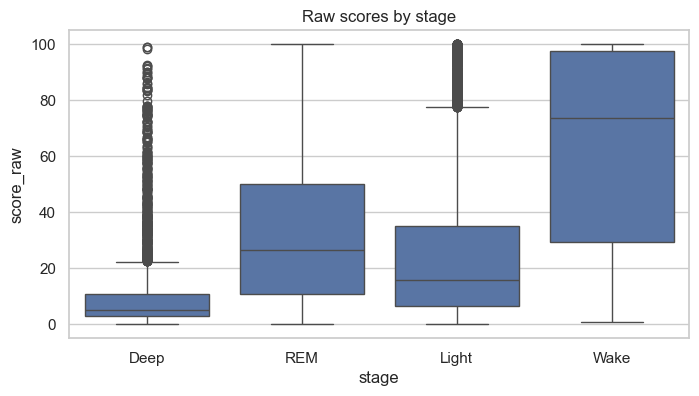

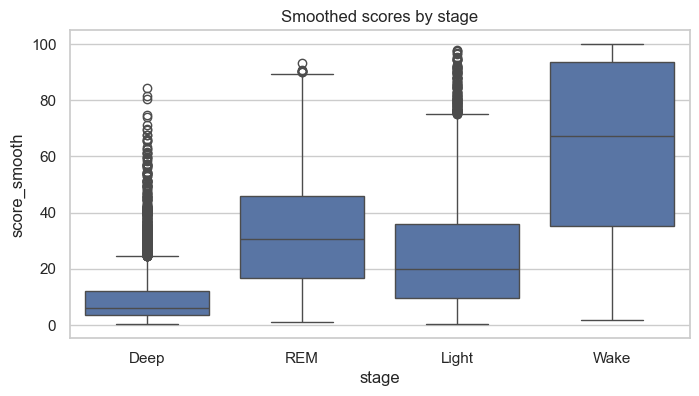

In [10]:

plt.figure(figsize=(8,4))
sns.boxplot(x='stage', y='score_raw', data=base_df,
            order=['Deep','REM','Light','Wake'])
plt.title('Raw scores by stage')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='stage', y='score_smooth', data=base_df,
            order=['Deep','REM','Light','Wake'])
plt.title('Smoothed scores by stage')
plt.show()


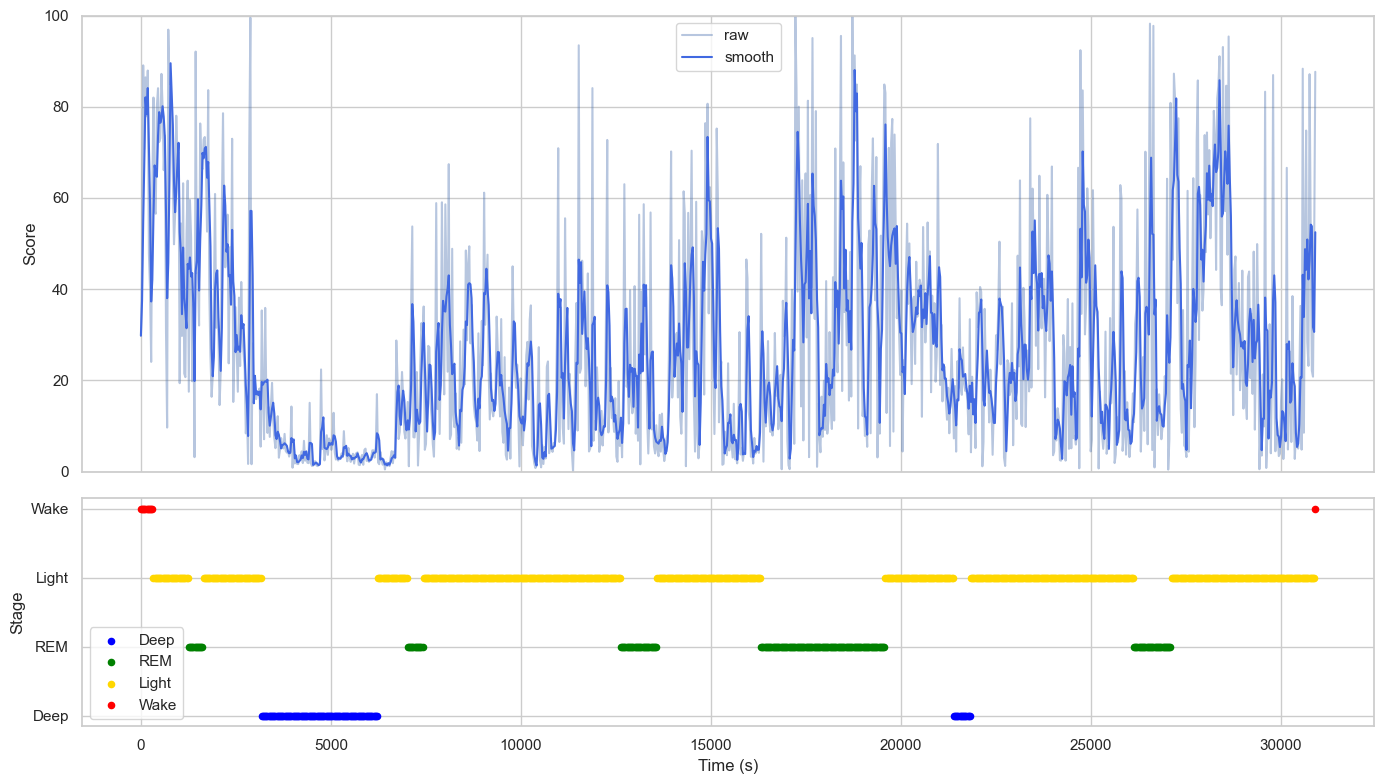

In [11]:

rec=base_df['record'].iloc[0]
sample=base_df[base_df['record']==rec].copy()
t=np.arange(len(sample))*EPOCH_SEC
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(14,8),
                           gridspec_kw={'height_ratios':[2,1]})
ax1.plot(t, sample['score_raw'], label='raw', alpha=0.4)
ax1.plot(t, sample['score_smooth'], label='smooth', color='royalblue')
ax1.set_ylabel('Score'); ax1.legend(); ax1.set_ylim(0,100); ax1.grid(True)
colors={'Deep':'blue','REM':'green','Light':'gold','Wake':'red'}
for st,c in colors.items():
    m=sample['stage']==st
    ax2.scatter(t[m],[st]*m.sum(),c=c,label=st,s=20)
ax2.set_ylabel('Stage'); ax2.set_xlabel('Time (s)'); ax2.legend(); ax2.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

with open('alertness_best_variant.pkl','wb') as f:
    pickle.dump({'variant':best_variant,'model':best['model'],'cols':best['cols']}, f)
print("Saved model & metadata.")

Saved model & metadata.
